In [397]:
# Insert path to dataset file into string below
path_to_file = "ММШІ КН ФКНК КНУТШ/Навчальні та робочі матеріали/Актуальні проблеми \"Data Mining\"/product_classification_and_clustering.csv"

In [1]:
!pip install -q --upgrade sentence-transformers
!pip install -q --upgrade pyclustering

In [30]:
from google.colab import drive
import sys
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import scipy
from scipy.cluster.hierarchy import linkage, fcluster, set_link_color_palette, dendrogram
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.kmedoids import kmedoids
import sentence_transformers
from sentence_transformers import SentenceTransformer

print("Python version:                 " + sys.version)
print("MatPlotLib version:             " + mpl.__version__)
print("Plotly version:                 " + plotly.__version__)
print("SciPy version:                  " + scipy.__version__)
print("NumPy version:                  " + np.__version__)
print("Pandas version:                 " + pd.__version__)
print("SciKit-Learn version:           " + sklearn.__version__)
print("SentenceTransformers version:   " + sentence_transformers.__version__)

Python version:                 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
MatPlotLib version:             3.10.0
Plotly version:                 5.24.1
SciPy version:                  1.14.1
NumPy version:                  2.0.2
Pandas version:                 2.2.2
SciKit-Learn version:           1.6.1
SentenceTransformers version:   4.0.2


**Product Classification and Clustering:** https://archive.ics.uci.edu/dataset/837/product+classification+and+clustering

In [4]:
drive.mount("/content/google-drive", force_remount=True)
dataset = pd.read_csv("/content/google-drive/MyDrive/" + path_to_file)
dataset.columns = dataset.columns.str.strip()
dataset

Mounted at /content/google-drive


,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
0,1,apple iphone 8 plus 64gb silver,1,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
1,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
...,...,...,...,...,...,...,...
35306,47350,smeg fab28 60cm retro style right hand hinge f...,59,47517,Smeg FAB28 Cream,2623,Fridges
35307,47351,smeg fab28 60cm retro style left hand hinge fr...,59,47518,Smeg FAB28 Red,2623,Fridges
35308,47352,smeg fab28 60cm retro style left hand hinge fr...,59,47519,Smeg FAB28 Pink,2623,Fridges
35309,47355,candy 60cm built under larder fridge cru160nek,125,47524,Candy CRU16.0,2623,Fridges


In [5]:
print(f"Number of duplicated rows:   {dataset.duplicated().sum()}\n")

print("Column           Number of missing values ​​(NaN)")
number_missing_values = dataset.isnull().sum()
for column, value in number_missing_values.items():
    print(f"{column:<15}  {value}")

print("\nColumn           Data type")
for column, data_type in dataset.dtypes.items():
    print(f"{column:<15}  {data_type}")

print("\nColumn           Number of unique values")
for column in dataset.columns:
    unique_vals = dataset[column].nunique()
    print(f"{column:<15}  {unique_vals}")

Number of duplicated rows:   0

Column           Number of missing values ​​(NaN)
Product ID       0
Product Title    0
Merchant ID      0
Cluster ID       0
Cluster Label    0
Category ID      0
Category Label   0

Column           Data type
Product ID       int64
Product Title    object
Merchant ID      int64
Cluster ID       int64
Cluster Label    object
Category ID      int64
Category Label   object

Column           Number of unique values
Product ID       35311
Product Title    30993
Merchant ID      306
Cluster ID       13233
Cluster Label    12849
Category ID      10
Category Label   10


In [6]:
dataset = dataset[["Product Title"]]
dataset

,Product Title
0,apple iphone 8 plus 64gb silver
1,apple iphone 8 plus 64 gb spacegrau
2,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...
3,apple iphone 8 plus 64gb space grey
4,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...
...,...
35306,smeg fab28 60cm retro style right hand hinge f...
35307,smeg fab28 60cm retro style left hand hinge fr...
35308,smeg fab28 60cm retro style left hand hinge fr...
35309,candy 60cm built under larder fridge cru160nek


**TF-IDF can't be used;**

In [7]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(dataset["Product Title"].astype(str).tolist(), batch_size=64, show_progress_bar=True)
embeddings

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/552 [00:00<?, ?it/s]

array([[-0.04862458,  0.06074519,  0.11684724, ..., -0.13415858,
         0.00141609, -0.0193512 ],
       [ 0.01790385,  0.02852999,  0.04680477, ..., -0.01027459,
         0.02087128, -0.00809558],
       [-0.0439685 ,  0.07585099,  0.10846493, ..., -0.07764998,
         0.01358182,  0.00466175],
       ...,
       [-0.07728802,  0.06683791, -0.04002273, ..., -0.0019021 ,
        -0.07069734,  0.07928404],
       [-0.07602095,  0.11496159, -0.07047395, ..., -0.07278604,
        -0.04548577,  0.04483862],
       [-0.08959911,  0.07667141, -0.06020064, ..., -0.08393028,
         0.00037268,  0.12479634]], dtype=float32)

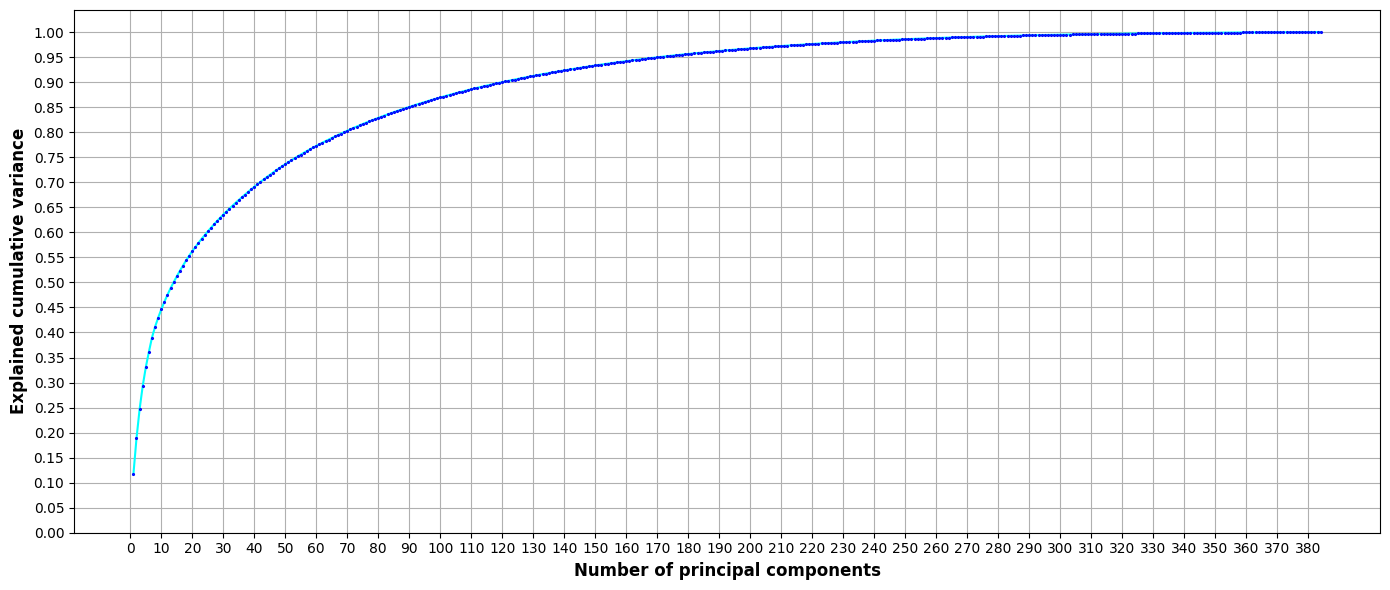

Number of principal components to retain 25% explained cumulative variance: 3


In [8]:
pca = PCA()
pca.fit(embeddings)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(14, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
         marker=".", markersize=1.5, markerfacecolor="blue",
         markeredgewidth=1.5, markeredgecolor="blue", color="cyan")
plt.xticks(np.arange(0, len(cumulative_variance) + 1, step=10))
plt.yticks(np.arange(0, 1.05, step=0.05))
plt.xlabel("Number of principal components", fontsize=12, fontweight="bold")
plt.ylabel("Explained cumulative variance", fontsize=12, fontweight="bold")
plt.grid(True)
plt.tight_layout()
plt.show()

desired_explained_cumulative_variance = 0.246
number_principal_components = np.argmax(cumulative_variance >= desired_explained_cumulative_variance) + 1
print(f"Number of principal components to retain {desired_explained_cumulative_variance * 100:.0f}% explained cumulative variance: {number_principal_components}")

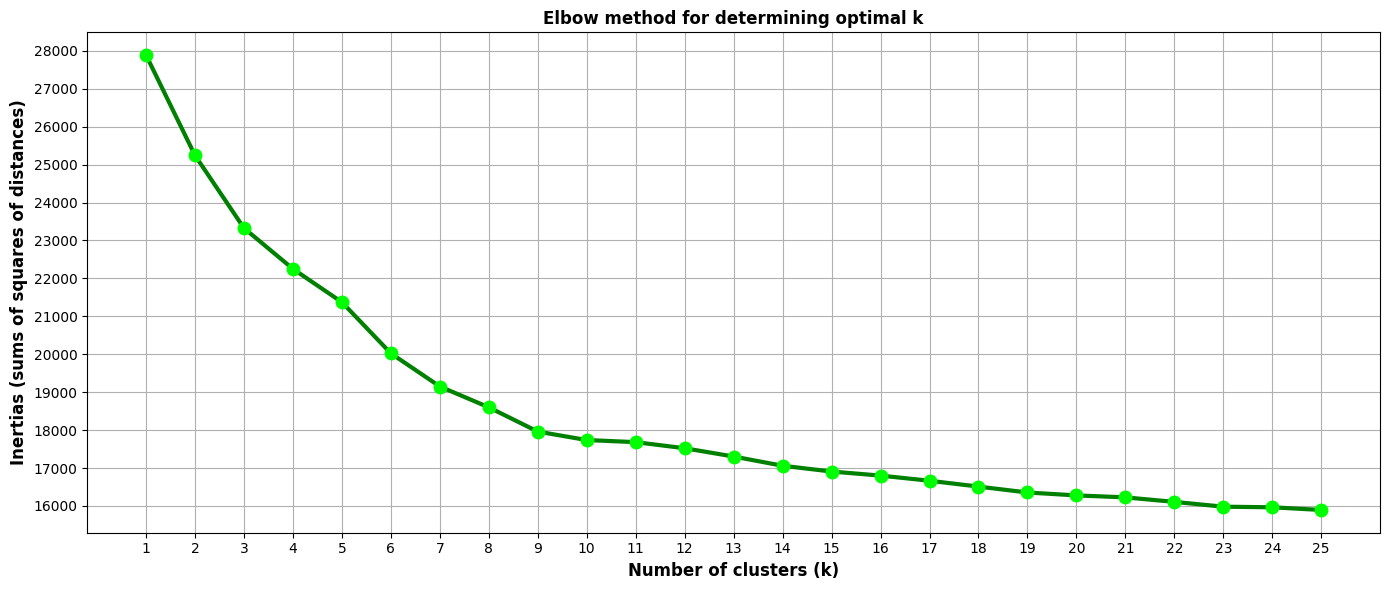

In [9]:
k_values = range(1, 26)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init="auto", random_state=42)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))
plt.plot(k_values, inertias,
         marker='o', markersize=5, markerfacecolor="lime",
         markeredgewidth=5, markeredgecolor="lime",
         color="green", linewidth=3)
plt.title("Elbow method for determining optimal k", fontsize=12, fontweight="bold")
plt.xlabel("Number of clusters (k)", fontsize=12, fontweight="bold")
plt.ylabel("Inertias (sums of squares of distances)", fontsize=12, fontweight="bold")
plt.xticks(k_values)
plt.yticks(range(16000, 28001, 1000))
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
kmeans = KMeans(n_clusters=7, init="k-means++", n_init="auto", random_state=42)
clusters_labels = kmeans.fit_predict(embeddings)

pca_kmeans = PCA(n_components=3)
embeddings_kmeans = pca_kmeans.fit_transform(embeddings)
fig = px.scatter_3d(
    x=embeddings_kmeans[:, 0],
    y=embeddings_kmeans[:, 1],
    z=embeddings_kmeans[:, 2],
    color=clusters_labels.astype(str),
    color_discrete_sequence=["red", "orange", "yellow", "green", "cyan", "blue", "purple"],
    labels={"color": "Cluster"}
)
fig.update_traces(marker=dict(size=5, opacity=0.75))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()

In [93]:
products_indices = np.random.choice(len(embeddings), size=int(0.0567 * len(embeddings)), replace=False)
embeddings_subsample = embeddings[products_indices]
embeddings_subsample.shape

(2002, 384)

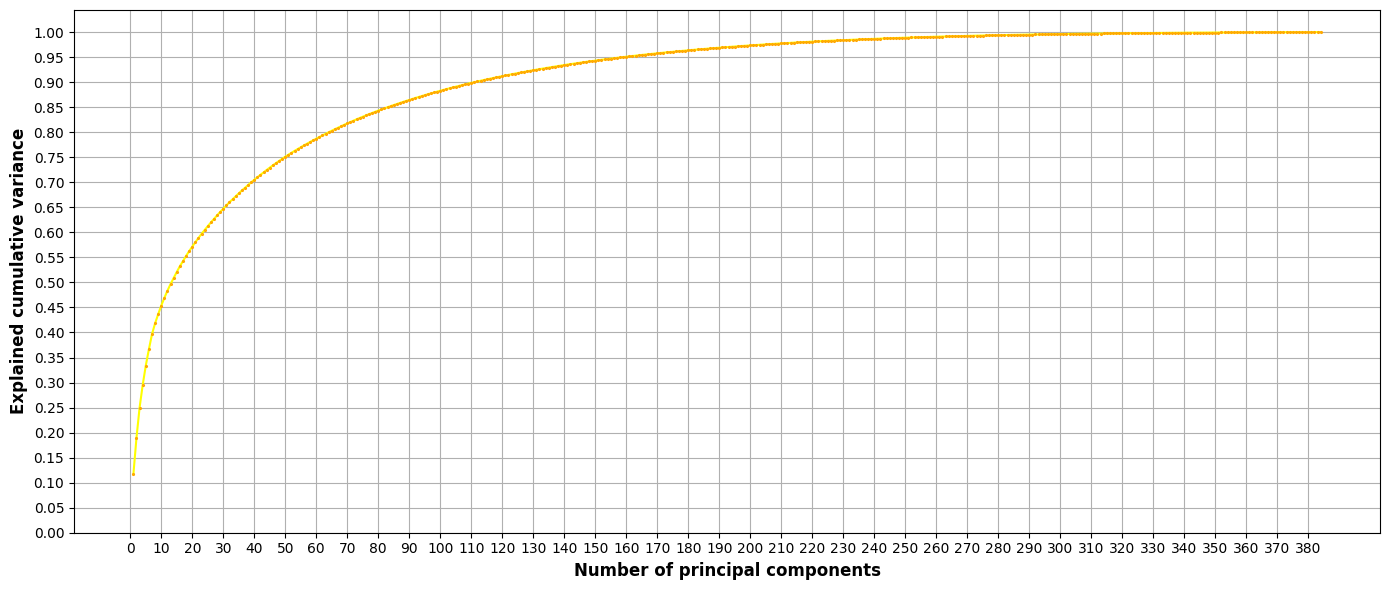

Number of principal components to retain 80% explained cumulative variance: 65


In [12]:
pca = PCA()
pca.fit(embeddings_subsample)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(14, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
         marker=".", markersize=1.5, markerfacecolor="orange",
         markeredgewidth=1.5, markeredgecolor="orange", color="yellow")
plt.xticks(np.arange(0, len(cumulative_variance) + 1, step=10))
plt.yticks(np.arange(0, 1.05, step=0.05))
plt.xlabel("Number of principal components", fontsize=12, fontweight="bold")
plt.ylabel("Explained cumulative variance", fontsize=12, fontweight="bold")
plt.grid(True)
plt.tight_layout()
plt.show()

desired_explained_cumulative_variance = 0.8
number_principal_components = np.argmax(cumulative_variance >= desired_explained_cumulative_variance) + 1
print(f"Number of principal components to retain {desired_explained_cumulative_variance * 100:.0f}% explained cumulative variance: {number_principal_components}")

In [94]:
pca_kmedoids = PCA(n_components=65)
embeddings_subsample = pca_kmedoids.fit_transform(embeddings_subsample)
embeddings_subsample.shape

(2002, 65)

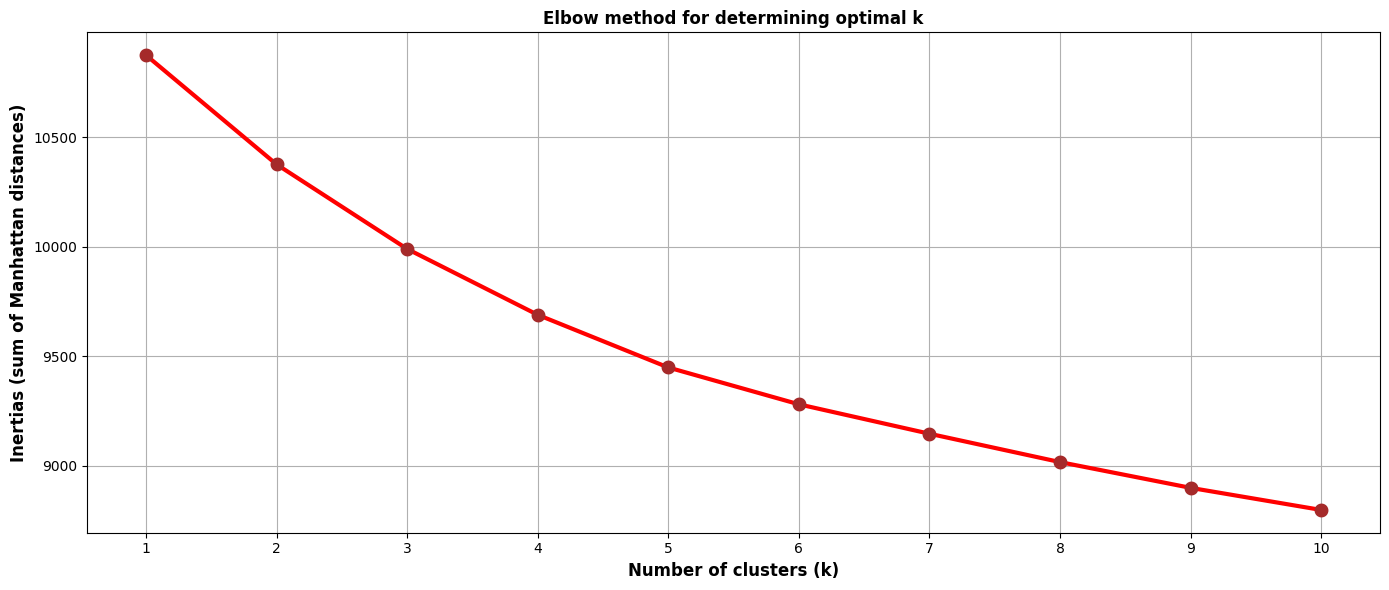

In [14]:
k_values = range(1, 11)
inertias = []

for k in k_values:
    kmedoids_instance = kmedoids(
        data=embeddings_subsample,
        initial_index_medoids=random.sample(range(len(embeddings_subsample)), k),
        metric=distance_metric(type_metric.MANHATTAN),
        itermax=100
    )
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()
    total_distance = 0
    for cluster, medoid_index in zip(clusters, medoids):
        medoid = embeddings_subsample[medoid_index]
        for index in cluster:
            total_distance += np.sum(np.abs(embeddings_subsample[index] - medoid))
    inertias.append(total_distance)

plt.figure(figsize=(14, 6))
plt.plot(k_values, inertias,
         marker='o', markersize=5, markerfacecolor="brown",
         markeredgewidth=5, markeredgecolor="brown",
         color="red", linewidth=3)
plt.title("Elbow method for determining optimal k", fontsize=12, fontweight="bold")
plt.xlabel("Number of clusters (k)", fontsize=12, fontweight="bold")
plt.ylabel("Inertias (sum of Manhattan distances)", fontsize=12, fontweight="bold")
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
kmedoids_instance = kmedoids(
    data=embeddings_subsample,
    initial_index_medoids=random.sample(range(len(embeddings_subsample)), 6),
    metric=distance_metric(type_metric.MANHATTAN),
    itermax=100
)
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
clusters_labels = np.zeros(len(embeddings_subsample), dtype=int)
for cluster_id, points in enumerate(clusters):
    clusters_labels[points] = cluster_id

pca_kmedoids = PCA(n_components=3)
embeddings_kmedoids = pca_kmedoids.fit_transform(embeddings_subsample)
fig = px.scatter_3d(
    x=embeddings_kmedoids[:, 0],
    y=embeddings_kmedoids[:, 1],
    z=embeddings_kmedoids[:, 2],
    color=clusters_labels.astype(str),
    color_discrete_sequence=["red", "yellow", "green", "blue", "purple", "black"],
    labels={"color": "Cluster"}
)
fig.update_traces(marker=dict(size=5, opacity=0.75))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()

In [69]:
products_indices = np.random.choice(len(embeddings_subsample), size=200, replace=False)
embeddings_subsample_for_dendrogram = embeddings_subsample[products_indices]
embeddings_subsample_for_dendrogram.shape

(200, 65)

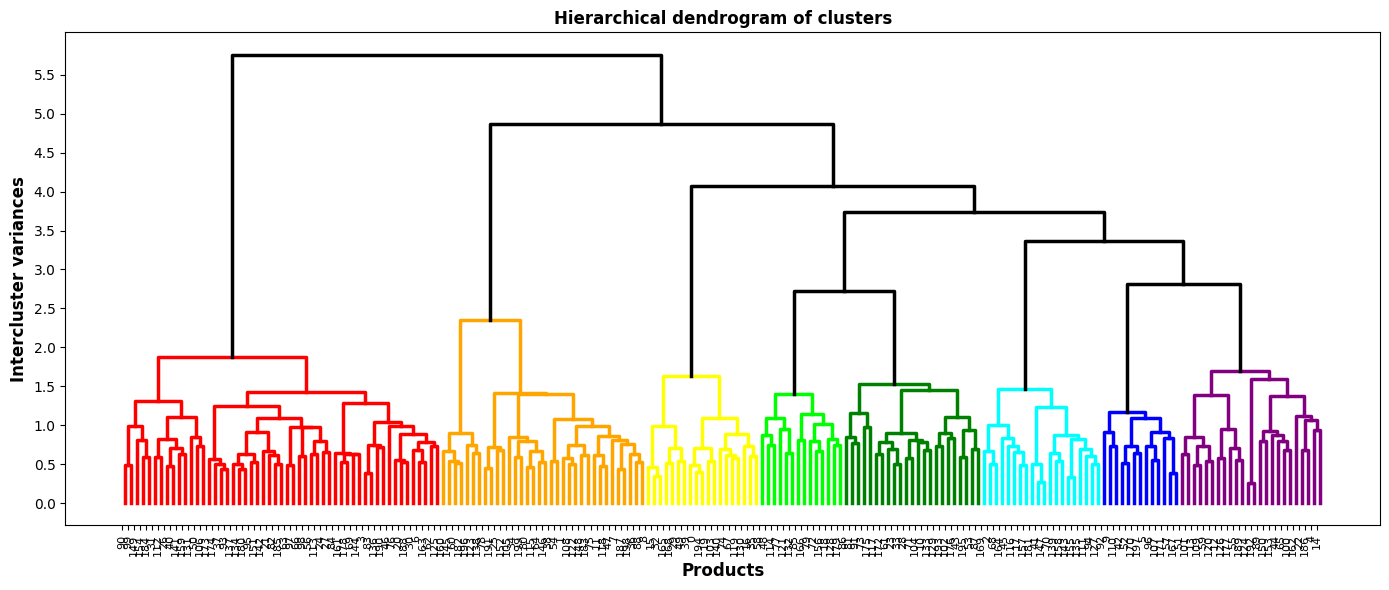

In [17]:
linkage_matrix = linkage(embeddings_subsample_for_dendrogram, method="ward")
clusters_colors = ["red", "orange", "yellow", "lime", "green", "cyan", "blue", "purple"]
set_link_color_palette(clusters_colors[:len(np.unique(fcluster(linkage_matrix, t=2.5, criterion="distance")))])
data = dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=8, color_threshold=2.5, above_threshold_color="black", no_plot=True)
fig, ax = plt.subplots(figsize=(14, 6))
for icoord, dcoord, color in zip(data["icoord"], data["dcoord"], data["color_list"]):
    ax.plot(icoord, dcoord, color, linewidth=2.5)
ax.set_xticks([tick for tick in range(0, 10 * len(data["ivl"]), 10)])
ax.set_xticklabels(data["ivl"], rotation=90, fontsize=8)
ax.set_yticks(np.arange(0, 6, 0.5))
plt.title("Hierarchical dendrogram of clusters", fontsize=12, fontweight="bold")
plt.xlabel("Products", fontsize=12, fontweight="bold")
plt.ylabel("Intercluster variances", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

In [18]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=8, linkage="ward")
clusters_labels = agglomerative_clustering.fit_predict(embeddings_subsample)

pca_agglomerative_clustering = PCA(n_components=3)
embeddings_agglomerative_clustering = pca_agglomerative_clustering.fit_transform(embeddings_subsample)
fig = px.scatter_3d(
    x=embeddings_agglomerative_clustering[:, 0],
    y=embeddings_agglomerative_clustering[:, 1],
    z=embeddings_agglomerative_clustering[:, 2],
    color=clusters_labels.astype(str),
    color_discrete_sequence=["red", "orange", "yellow", "lime", "green", "cyan", "blue", "purple"],
    labels={"color": "Cluster"}
)
fig.update_traces(marker=dict(size=5, opacity=0.75))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()

In [377]:
results = []
for epsilon in np.arange(0.5, 10.1, 0.5):
    for min_samples in range(3, 11):
        dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric="manhattan")
        clusters_labels = dbscan.fit_predict(embeddings_subsample)
        valid_clusters_labels = set(clusters_labels) - {-1}
        if len(valid_clusters_labels) > 1:
            score = silhouette_score(embeddings_subsample, clusters_labels, metric="manhattan")
        else:
            score = -1
        results.append({
            "epsilon": epsilon,
            "min_samples": min_samples,
            "silhouette_score": score,
            "clusters_number": len(valid_clusters_labels)
        })

results_dataframe = pd.DataFrame(results)
print("Best measured hyperparameters for DBSCAN:")
for key, value in results_dataframe.loc[results_dataframe["silhouette_score"].idxmax()].items():
    print(f"{key.ljust(16)}   {value}")

Best measured hyperparameters for DBSCAN:
epsilon            4.0
min_samples        5.0
silhouette_score   0.07340580888904796
clusters_number    10.0


In [396]:
dbscan = DBSCAN(eps=4, min_samples=5, metric="manhattan", algorithm="auto")
clusters_labels = dbscan.fit_predict(embeddings_subsample)

pca_dbscan = PCA(n_components=3)
embeddings_dbscan = pca_dbscan.fit_transform(embeddings_subsample)
fig = px.scatter_3d(
    x=embeddings_dbscan[:, 0],
    y=embeddings_dbscan[:, 1],
    z=embeddings_dbscan[:, 2],
    color=clusters_labels.astype(str),
    color_discrete_sequence=["brown", "red", "orange", "yellow", "lime", "green", "cyan", "blue", "purple", "pink", "black"],
    labels={"color": "Cluster"}
)
fig.update_traces(marker=dict(size=5, opacity=0.75))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()